Задача: создать алгоритм, отличающий экономические новости от любых других

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Размеченный новостной датасет был взят с сайта: https://www.kaggle.com/amananandrai/ag-news-classification-dataset

In [42]:
# читаем данные

data = pd.read_csv('data.csv', encoding='utf-8')
data.head(10)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...
8,3,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...
9,3,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre..."


In [43]:
# переименовываем столбцы для удобства
data = data.rename(columns ={"Class Index": "Class"})

display(data)

,Class,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [44]:
# размечаем экономические новости и все остальные
data.loc[data.Class != 3, 'Class'] = "Other"
data.loc[data.Class == 3, 'Class'] = "Economy"

display(data)

,Class,Title,Description
0,Economy,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,Economy,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,Economy,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,Economy,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,Economy,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,Other,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,Other,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,Other,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,Other,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


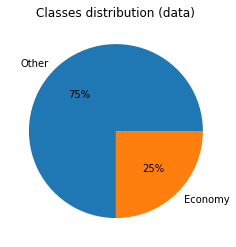

In [45]:
# наглядная демонстрация того, что экономических новостей в датасете 25%
classes1 = pd.value_counts(data["Class"])

classes1.plot(kind = 'pie',  autopct='%0.f%%') 

plt.title("Classes distribution (data)")

plt.ylabel('')

plt.show()

Ищем частоты слов в сообщениях (отдельно для подкорпуса экономических новостей и остальных). Для будущего алгоритма, слова будут признаками (features).

Для этого используем Counter из collections.

In [46]:
# заберем все слова по условию, заджойним в строку, разобьем по пробелам, возьмем топ-20
count1 = Counter(" ".join(data[data['Class']=='Economy']["Description"]).lower().split()).most_common(20) 
df1 = pd.DataFrame.from_dict(count1) # новый дф
df1 = df1.rename(columns={0: "words in economic news", 1 : "count"})

# тот же набор операций для второго подкорпуса
count2 = Counter(" ".join(data[data['Class']=='Other']["Description"]).lower().split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in other news", 1 : "count"})

display(df1,df2)

,words in economic news,count
0,the,43185
1,a,23856
2,to,23073
3,of,20691
4,in,18551
5,and,16338
6,on,13441
7,for,9245
8,its,9183
9,-,8851


,words in other news,count
0,the,153718
1,a,78623
2,to,72071
3,of,68113
4,in,59168
5,and,49271
6,on,33411
7,-,29170
8,for,28439
9,that,20020


In [47]:
# избавляемся от стоп-слов
f = feature_extraction.text.CountVectorizer(stop_words = 'english') 

In [48]:
X = f.fit_transform(data["Description"])
# print(f.get_feature_names()) # посмотрим на признаки

display(X.shape)
# display(X.toarray())

(120000, 60431)

В датасете 60431 признак (по числу уникальных слов в корпусе).

In [49]:
data["Class"]=data["Class"].map({'Economy':1,'Other':0}) # переименуем значения 'Economy' в 1  и 'Other' в 0

display(data)

,Class,Title,Description
0,1,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,1,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,1,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,1,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,1,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,0,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,0,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,0,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,0,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


Создадим новые переменные:

- X_train - кусочек матрицы "документ/термин", который отдается алгоритму для обучения
- X_test - кусочек матрицы "документ/термин", на котором проверяется алгоритм
- y_train - кусочек датафрейма с текстами для обучения
- y_test - кусочек датафрейма с текстами для проверки

In [50]:
# новые переменные
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['Class'], 
                                                                    test_size=0.2, random_state=50)
# print(X_train.shape, X_test.shape)
sum(y_test == 1)

5985

Применяется алгоритм наивного байеса (Multinomial NB)
Затем проверяется Precision, Recall и Accuracy

In [52]:
list_alpha = np.arange(1/100000, 20, 0.11) 
#возьмем лист равномерно распределенных значений от 1/100000 до 20(можно выбрать другие числа,эти были выбраны экспериментально)


score_train = np.zeros(len(list_alpha)) # задали пустые списки по длине изначального листа
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0

In [53]:
for alpha in list_alpha: # для каждого значения в списке альф
    bayes = naive_bayes.MultinomialNB(alpha=alpha) # используем модель
    bayes.fit(X_train, y_train) # тренируем модель
    
    score_train[count] = bayes.score(X_train, y_train) # итерируемся по индексу в листе, добавляем значения accuracy
    # score_train? 
    
    score_test[count]= bayes.score(X_test, y_test)
    # score_test ? 
    
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    
    count = count + 1 # после одной итерации, делаем новый шаг

посмотрим на 10 лучших моделей

In [54]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])


display(models.head(10))

display(matrix.shape)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.947094,0.919292,0.851128,0.829642
1,0.11001,0.937448,0.922875,0.886884,0.818883
2,0.22001,0.935656,0.922750,0.888722,0.817427
3,0.33001,0.934292,0.922708,0.889557,0.816815
4,0.44001,0.933354,0.922292,0.889557,0.815564
5,0.55001,0.932573,0.922083,0.889223,0.815132
6,0.66001,0.931958,0.921625,0.888221,0.814338
7,0.77001,0.931531,0.921208,0.886550,0.814053
8,0.88001,0.931302,0.921208,0.885380,0.814729
9,0.99001,0.931021,0.921125,0.884378,0.815060


(182, 5)

Оставляем модель с наивысшей test precision

In [56]:
best_index = models['Test Precision'].idxmax()
best_index

# display(best_index)

display(models.iloc[best_index])

alpha             19.910010
Train Accuracy     0.901875
Test Accuracy      0.901333
Test Recall        0.673684
Test Precision     0.906679
Name: 181, dtype: float64

In [67]:
models[models['Test Precision']==1]

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision


К сожалению, моделей со 100% Precision не оказалось

In [73]:
# из моделей с наибольшим Recall, выбираем модель с наибольшим Precision
models[models['Test Recall']>0.88].sort_values(by="Test Precision", ascending = False)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
1,0.11001,0.937448,0.922875,0.886884,0.818883
13,1.43001,0.930292,0.921583,0.880869,0.818506
12,1.32001,0.930438,0.921500,0.882038,0.817562
2,0.22001,0.935656,0.922750,0.888722,0.817427
3,0.33001,0.934292,0.922708,0.889557,0.816815
11,1.21001,0.930583,0.921417,0.883041,0.816721
10,1.10001,0.930719,0.921333,0.883876,0.815980
4,0.44001,0.933354,0.922292,0.889557,0.815564
5,0.55001,0.932573,0.922083,0.889223,0.815132
9,0.99001,0.931021,0.921125,0.884378,0.815060


Выбираем 1 модель, как наиболее точную. Делаем предикшн

In [77]:
bayes = naive_bayes.MultinomialNB(alpha= 0.11001) # используем лучшую модель
bayes.fit(X_train, y_train) # тренируем алгоритм на данных

bayes.predict(X_test) # метод для предсказания

# сделаем датафрейм с колонками для настоящего класса и для предсказанного

new_df = pd.DataFrame(data = y_test)
new_df["predicted"]=bayes.predict(X_test) # добавляем новую колонку с предсказаниями

new_df

,Class,predicted
110913,0,0
75136,1,0
48815,0,0
17853,0,0
61101,1,1
...,...,...
8944,0,0
77366,0,0
25946,0,0
36655,0,0


Построим матрицу ошибок

In [78]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))


pd.DataFrame(data = m_confusion_test, columns = ['Predicted economic news', 'Predicted other news'],
            index = ['Actual economic news', 'Actual other news'])

,Predicted economic news,Predicted other news
Actual economic news,16841,1174
Actual other news,677,5308


Алгоритм ошибся 1851 раз. 